<a name="top"></a>

# Main Analyses

## Contents:
* [Import Packages + Set up Paths](#import)


* [Connect to Mongo](#mongo)  


* [Save Dataframes from Each Experiment](#initialize)  
    * [Experiment 1.0](#exp1_data): sketcher data (T), viewer data (K), dyad data (D)
    * [Experiment 1.1](#exp1_rdat): recognizer data (R)
    * [Experiment 2.0](#exp2_data): sketcher data (T), viewer data (K), dyad data (D)
    * [Experiment 3.0](#exp3_data): sender data (S), receiver data (C), dyad data (D)  


* [Read Dataframes Back Up](#read_from_csv)
    * Can start here to read from locally stored data and save time


* [Summary Statistics](#summary_stats)
    * [Summary of the Data](#summary): Also includes some simple exploratory statistical tests
    * [Idealized Strategies](#strategies): How close are participants' messages to strategies we imagine a priori?   
    * [Orderedness](#orderedness): How often are symbols within messages in decreasing order of size?


* [Figures in Manuscript](#figures)
    * [Figure 2](#fig2)
    * [Figure 3](#fig3)
    * [Figure 4](#fig4)
    * [Figure 5](#fig5)


## <a name="import"></a> Import Packages + Set up Paths ([^](#top))

In [1]:
import os, sys
import pymongo as pm
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from skimage import io
from io import BytesIO
from PIL import Image
from IPython.display import SVG, display # need for showing stims with sketches side by side
import requests # this is to access the stim urls from the notebook
import base64
import PIL
import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42
from IPython.display import clear_output
import importlib
from collections import Counter # for counting games

# directory & file hierarchy
proj_dir =     os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir =  os.path.join(proj_dir,'results')
plot_dir =     os.path.join(results_dir,'plots')
csv_dir =      os.path.join(results_dir,'csv')
extra_dir =      os.path.join(csv_dir,'extra')

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,extra_dir]]

## add utils to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

from IPython.display import Image as image

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Some Functions & Settings

In [2]:
# set preferences for how we run this notebook (some operations are time-consuming)
save_images = True             # automatically save sketches + galleries for Experiments 1 & 2
extra_exclusions = False        # exclude a few games in Experiment 3 or not?

# set general preferences for figure aesthetics
lw = 2
cs = 1

# What is our colour palette? Others are #97b4c2 (simpsons err fill), #25B1F7 (exp1 stroke ratio line), #25B1F7 (exp2 bar fill)
c1 = '#7DCCF4'
c2 = '#787878' # '#0c54c7'
c3 = '#97b4c2'

np.random.seed(5)


In [3]:
def get_sketch(df,exp,ID,Gid,trialNum,sketch_dir=False):
    """
    Just a function that plots a sketch (specified by the gameID and trial number) with its target stimulus.
    Output of this function is the image showing both side by side.
    """
    game = df[df.gameID == ID]
    trial = game[game.trialNum == trialNum]
    stim_url = trial['Targ_s_Url'].values[0]
    get_stim = requests.get(stim_url)
    stim = Image.open(BytesIO(get_stim.content))
    correct = trial['outcome'].values[0]
    background_colour = "#1EB012" if correct == 1 else "#D31F13"
    get_sketch = trial['png'].values[0]
    sketch = Image.open(BytesIO(base64.b64decode(get_sketch)))
    
    sketch = sketch.resize((100,100))
    stim = stim.resize((100,100))
    
    images = [sketch,stim]
    widths, heights = zip(*(i.size for i in images))
    total_width = max(widths)
    max_height = sum(heights)
    whole_trial = Image.new('RGBA', (total_width, max_height),color=background_colour)
    y_offset = 0
    
    for im in images:
        whole_trial.paste(im, (0,y_offset))
        y_offset += im.size[1] + 5
    
    if sketch_dir != False:
        condition = df[df.gameID == ID]['Game_Condition'].values[0]
        fname = str(condition) + '_G' + str(Gid) + "_trial" + str(trialNum) + '_' + str(trial['target'].values[0])
        if not os.path.exists(os.path.join(sketch_dir,fname+'.png')):
            print('Rendering sketch...', fname + '.png')
            clear_output(wait=True)
            whole_trial.save(os.path.join(sketch_dir,fname+'.png'),'PNG')
    
    return whole_trial

def get_gallery(df,exp,ID,Gid,save_dir=False,by_trial=False):
    """
    This function takes in a gameID and shows sketches and their targets for every trial, side by side.
    Optionally, it will save this output into a png.
    exp is the experiment, 1 or 2. ID is gameID, Gid is a shorter integer id
    """
    d = df[df.gameID == ID]
    width = 32 if exp==1 else 36
    numTrials = int(d['trialNum'].max())
    sketch_dir = save_dir.replace("sketch_galleries","sketch")
    
    if by_trial == False:
        whole_game = Image.new('RGBA', (int(width*100/2), 410),color='white')
        whole_game.putalpha(0)
        cardinalities = np.sort(d['cardinality'].unique())
        animals = d['category'].unique()
        for i,c in enumerate(cardinalities):
            for j,a in enumerate(animals):
                # get all the instances of this cardinality-animal combo in the game (there are 2!)
                trialnums = d.loc[(d.cardinality == c) & (d.category == a)]['trialNum'].unique()
                for k,t in enumerate(trialnums):
                    
                    trial = get_sketch(df,exp,ID,Gid,int(t),sketch_dir=sketch_dir)
                    
                    whole_game.paste(trial,(j*100+i*300,k*205)) # k is binary - so either 0 or 205
    
    if by_trial == True:
        whole_game = Image.new('RGBA', (width*100, 205),color='white')
        whole_game.putalpha(0)
        for trial_num in np.arange(1,numTrials+1):
            trial = get_sketch(df,exp,ID,Gid,trial_num,sketch_dir=sketch_dir)
            whole_game.paste(trial,(trial_num*100-100,0))

            
    if save_dir != False:
        split_by = 'Game_Condition' if exp == 1 else 'Regularity'
        condition = df[df.gameID == ID][split_by].values[0]
        fname = str(condition) + '_G' + str(Gid) + "_gallery"
                    
        # now save the image out to that directory
        if not os.path.exists(os.path.join(save_dir,fname+'.png')):
            print('Rendering gallery...', fname + '.png')
            clear_output(wait=True)
            whole_game.save(os.path.join(save_dir,fname+'.png'),'PNG')
            
    return whole_game

def get_confint(df):
    """Takes a df already with columns ['Factors','mean','count','std'] """
    new_df = df
    ci95_hi = []
    ci95_lo = []
    for i in new_df.index:
        m, c, s = new_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    new_df['ci95_hi'] = ci95_hi
    new_df['ci95_lo'] = ci95_lo
    return new_df

def LD(token1, token2):
    """This function gives us the Levenshtein distance between two strings.
    We will use it to cluster games into categories based on which model strategies they are closest to"""
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

# check to see if the symbols are being used in a strictly decreasing order
def ordered(x,dis=False):
    """ Checks to see if a list is consistent with being (decreasingly) ordered """
    ordered = True # assume that the list is decreasingly ordered by default
    
    if dis == True & len(x) == 1: # if we are looking for places where it *could* be disordered but isn't
        ordered = np.nan # if there's only one symbol, it's meaningless whether it's ordered
    
    else: # most cases are this
        curItem = x[0] # start with first element of the list
        for i,item in enumerate(x):
            ordered = False if item > curItem else True # check to see if next element is greater than previous
            curItem = item
            if ordered == False:  # if any subsequent list item increases, then stop searching
                break
    return ordered

# as a control, posit a fake set of symbols that sums to the same number:
def getFakeMessage(x):
    """m for message, r for remainder"""
    r = x
    m = []
    while r > 0:
        new_symbol = np.random.choice(np.arange(1,r+1),1)
        m = np.append(m, new_symbol)
        r -= new_symbol
    return m.astype(int)


## <a name="mongo"></a> Connect to Mongo ([^](#top))

In [4]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [5]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']


## <a name="initialize"></a> Save Dataframes from Each Experiment ([^](#top))

### <a name="exp1_data"></a> Experiment 1 - Communication Task ([^](#top))

In [6]:
# prepare to pick out Experiment 1 communication data from mongo
coll = db['num8_shape4']
iterationNames = ['run2','run3','run4','run5','run6']

## fetch viewer records that match our list of iterationNames, then turn that into a dataframe for raw data
print("Fetching viewer data...")
clear_output(wait=True)
k = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'clickedObj'})
K = pd.DataFrame(list(k))

## now do the same for stroke data
print("Fetching sketcher data...")
clear_output(wait=True)
t = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'stroke'})
T = pd.DataFrame(list(t))

## get list of valid game IDs (i.e, subject number)
game_dict = Counter(K['gameid']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==32] ## get gameids that contributed exactly the right number of sketches

## take only stroke/sketch dataframes that are complete, and only bother if there are incomplete games
only_complete = True
if (only_complete and T['gameid'].nunique()!=len(complete_gameids)):
    T = T[(T['gameid'].isin(complete_gameids))].reset_index(drop=True)
    K = K[(K['gameid'].isin(complete_gameids))].reset_index(drop=True)

# save out to csv
T.drop(columns=['workerId']).to_csv(os.path.join(csv_dir,'extra/exp1_stroke_raw.csv'),index=False) # anonymize
K.drop(columns=['workerId']).to_csv(os.path.join(csv_dir,'extra/exp1_sketch_raw.csv'),index=False) # anonymize

print("There are {} complete games.".format(len(complete_gameids)))

There are 67 complete games.


In [7]:
# uncomment these to generate D again
D = utils.generate_dataframe(coll, complete_gameids, "1", csv_dir)

# Turning things that can be numeric into numeric things
D = D.astype({'trialNum': 'float',
              'cardinality': 'float',
              'drawDuration': 'float',
              'outcome': 'float',
              'numStrokes': 'float',
              'meanPixelIntensity': 'float',
              'numCurvesPerSketch': 'float',
              'numCurvesPerStroke': 'float',
              'D1_Car': 'float',
              'D2_Car': 'float',
              'D3_Car': 'float'})

# Keep track of which quarter of the experiment the trial happened in
D['block'] = np.ceil(D['trialNum'] / 8)          # group trials into blocks
D['cardinality'] = D['cardinality'] + 1          # cardinalities are 0-indexed, which is ugly
D['ratio'] = D['numStrokes'] / D['cardinality']  # stroke ratio
D = D.astype({'block': 'float'})                 # need this as numeric

/Users/alles/repos/iterated_number/utils/utils.py:393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  [GameID,TrialNum, Target, Category, Cardinality, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, numCurvesPerSketch, numCurvesPerStroke, timedOut,png, svgString, D1, D1_Cat, D1_Car, D2, D2_Cat, D2_Car, D3, D3_Cat, D3_Car, Game_Condition, Targ_s_Url, Targ_v_Url, Dis_s_Urls, Dis_v_Urls, viewer_sees_images, Regularity])


Done.


In [8]:
# are we looking at all complete games, or only ones that pass the criteria for analysis?
exclude = True

# Export the csv a first time with all the data - including everyone we'll have to exclude
D.to_csv(os.path.join(csv_dir,'extra/exp1_dyad_raw.csv'))


# First clean it up by removing games that we have to exclude. Some exclusions require looking first:
dud_games = ["8369-76e6f73d-922a-4aca-b98a-8c96026aa48a",    #number; excluded because of below-threshold accuracy
             "1372-60cdfd55-28bb-411c-b777-c51eaadee7a9",    #shape; below-threshold accuracy
             "2949-1e579088-8493-4c07-873c-7bd6d00685e3",    #shape; included pre-existing symbols
             "7197-6d1f3fda-040a-455c-aef0-279ba9aef053",    #shape; included pre-existing symbols
             "9237-4cc76e85-9955-4cef-b03c-5c68f46321ca",    #shape; below-threshold accuracy
             "1947-29382ba4-5747-456d-ba8b-276812fc1fb3"]    #shape; below-threshold accuracy

# there are also automatically detectable criteria for exclusion
low_acc_games = D[D['low_acc'] == True]['gameID'].unique()    # unusually low accuracy
failed_games =  D[D['failed'] == True]['gameID'].unique()    # below 50% accuracy

# the names of the games we want to keep
games_list = [game for game in complete_gameids if game not in dud_games] if exclude == True else complete_gameids

# now exclude games that didn't meet analysis criteria
D = D[(D['gameID'].isin(games_list))].reset_index(drop=True)

# simplify the game IDs
codenames = dict(zip(D['gameID'].unique(),np.arange(1,len(D['gameID'].unique())+1)))
D['gameID'] = D['gameID'].apply(lambda x: codenames[x])

# Export the csv again. This is what the R script will look at
D.to_csv(os.path.join(csv_dir,'exp1_dyad.csv'))

print("Done")

Done


In [9]:
# now save qualitative data to file, if we have enabled it
if save_images == True:
    for i,game_id in enumerate(D['gameID'].unique()):
        print("Now generating sketch + stim display for ",game_id)
        clear_output(wait=True)
        get_gallery(D,1,game_id,i,save_dir='../results/sketch_galleries/exp1',by_trial=True)

        
# # if we want to also generate sketches readable to VGG-19, uncomment the rest of this
# k1 = pd.read_csv(os.path.join(csv_dir,'extra/exp1_sketch_raw.csv'))
# k1 = k1.loc[k1['gameid'].isin(D1['gameID'].unique())]

# importlib.reload(utils)
# utils.render_images(k1,data = 'pngString',
#                     metadata = ['gameid','intendedName','trialNum','game_condition'],
#                     targ_url = ['targ_s_url'],
#                     out_dir = "../results/bare_sketches",
#                     targ_dir = "../results/bare_targets",
#                     delimiter = '_',
#                     savetargs = True)


print("Done")

Done


### <a name="exp1_rdat"></a> Experiment 1 - Recognition Task ([^](#top))

In [10]:
# prepare to pick out Experiment 1 recognition data from mongo
coll = db['num8_shape4_recognition']
iterationName = 'run1'

## fetch records that match our list of iterationNames
print("Fetching recognition task data...")
clear_output(wait=True)
r = coll.find({'iterationName': iterationName})
R = pd.DataFrame(list(r))

## get list of valid game IDs (i.e, subject number)
game_dict = Counter(R['recog_gameID']) ## get dictionary mapping gameIDs to number of trials 
complete_gameids = [r for (r,v) in game_dict.items() if v==65]    # 65 trials is a full game in this one

## subset stroke/sketch dataframes by being complete
only_complete = True
if (only_complete and R['recog_gameID'].nunique()!=len(complete_gameids)):
    R = R[(R['recog_gameID'].isin(complete_gameids))].reset_index(drop=True)

# rename columns for shorter reference
R = R.rename(columns={"recog_gameID":"RgameID",
                      "orig_game_id":"OgameID", 
                      "rating_trial_num":"Rtrial",
                      "orig_game_trial_num":"Otrial",
                      "rate_condition":"Rcond",
                      "orig_game_condition":"Ocond",
                      "orig_sketch_animal":"shape",
                      "orig_sketch_cardinality":"cardinality"
                     })

# Turning things that can always be numeric into numeric things
R = R.astype({'cardinality': 'float',
              'Rtrial': 'float',
              'Otrial': 'float'})

# For accuracy, we have to compare a different set of columns, depending each rating condition
R['correct'] = R.apply(lambda x: float(x['rating']) == x['cardinality'] if x['Rcond'] == 'number' else x['rating'] == x['shape'],axis=1)

R = R.astype({'correct': 'float'})      

# need to add trial block of original game here, as well
R['block'] = np.ceil(R['Otrial'] / 8)

# convert milliseconds to seconds
R['RT'] = R['RT'] / 1000

# finally, what we're really interested in is whether recognizers are in the same or different condition as communicators
R['sameCond'] = R['Ocond'] == R['Rcond']

# save out to csv
R.drop(columns=['workerID']).to_csv(os.path.join(csv_dir,'extra/exp1_recog_raw.csv'),index=False) # anonymize

print("There are {} complete recognition games.".format(len(complete_gameids)))

There are 264 complete recognition games.


In [11]:
# how many distinct recog participants completed all trials of the game, prior to exclusion criteria?
num_complete_raters = len(R.workerID.unique())

# make a dataframe showing each recognizer's catch trial accuracy
catches = R[R['catch_trial'] == True]
catch_acc = pd.DataFrame(catches.groupby(['RgameID','workerID'])['correct'].mean())
catch_acc = catch_acc.rename(columns={"correct": "catch_accuracy"})
num_games = len(catch_acc)

# now get a list of the gameIDs who got perfect score on catch trials and filter everyone else out of the big DF
kosher_games = list(catch_acc[catch_acc['catch_accuracy'] == 1.0].reset_index()['RgameID'])
is_kosher = R.RgameID.isin(kosher_games) # get the indices of games that pass. Boolean series
R = R[is_kosher] # now filter R to include only those games that passed
R = R[R['catch_trial'] == False] # now remove all catch trials from R, as we don't need to analyse them
num_kosher_games = len(kosher_games)

print("{} recog games passed all catch trials, out of {} total.".format(num_kosher_games,num_games))
print("{} total unique workers passed this stage".format(len(R.workerID.unique())))

# get all the workers who participated in the production task
workerList = np.append(K['workerId'].unique(),T['workerId'].unique())
is_repeat = R.workerID.isin(workerList)
R = R[~is_repeat]
num_naive = len(R.workerID.unique())
num_games_naive = len(R.RgameID.unique())

print("{} recog participants completed all trials.".format(num_complete_raters))
print("{} recog participants not repeated from production.".format(num_naive))
print("{} recog games not from repeaters, out of {} total.".format(num_games_naive,num_kosher_games))
print("{} total unique workers passed this stage".format(len(R.workerID.unique())))

# simplify the game IDs
codenames = dict(zip(R['RgameID'].unique(),np.arange(1,len(R['RgameID'].unique())+1)))
R['RgameID'] = R['RgameID'].apply(lambda x: codenames[x])

# now save out the whole dataframe so we can run analyses in R:
R.drop(columns=['workerID']).to_csv(os.path.join(csv_dir,"exp1_recog.csv")) # anonymize

232 recog games passed all catch trials, out of 264 total.
198 total unique workers passed this stage
211 recog participants completed all trials.
190 recog participants not repeated from production.
221 recog games not from repeaters, out of 232 total.
190 total unique workers passed this stage


### <a name="exp2_data"></a> Experiment 2 ([^](#top))

In [12]:
# prepare to pick out Experiment 2 communication data from mongo
coll = db['num6_shape3']
iterationNames = ['regularity1','run1']

## fetch viewer records that match our list of iterationNames, then turn that into a dataframe for raw data
print("Fetching viewer data...")
clear_output(wait=True)
k = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'clickedObj'})
K = pd.DataFrame(list(k))

## now do the same for stroke data
print("Fetching sketcher data...")
clear_output(wait=True)
t = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'stroke'})
T = pd.DataFrame(list(t))

# make a new column for viewer reaction time
K['vRT'] = K['clickedTime'] - K['submitTime'] # viewer reaction time

# convert to seconds so that it's easier to read
K['vRT'] = K['vRT'] / 1000

## get list of valid game IDs (i.e, subject number)
game_dict = Counter(K['gameid']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==36] ## get gameids that contributed exactly the right number of sketches

## take only stroke/sketch dataframes that are complete, and only bother if there are incomplete games
only_complete = True
if (only_complete and T['gameid'].nunique()!=len(complete_gameids)):
    T = T[(T['gameid'].isin(complete_gameids))].reset_index(drop=True)
    K = K[(K['gameid'].isin(complete_gameids))].reset_index(drop=True)

# save out to csv
T.drop(columns=['workerId']).to_csv(os.path.join(csv_dir,'extra/exp2_stroke_raw.csv'),index=False) # anonymize
K.drop(columns=['workerId']).to_csv(os.path.join(csv_dir,'extra/exp2_sketch_raw.csv'),index=False) # anonymize

print("There are {} complete games.".format(len(complete_gameids)))

There are 100 complete games.


In [13]:
# uncomment these to generate D again
D = utils.generate_dataframe(coll, complete_gameids, "2", csv_dir)

# Turning things that can be numeric into numeric things
D = D.astype({'trialNum': 'float',
              'cardinality': 'float',
              'drawDuration': 'float',
              'outcome': 'float',
              'numStrokes': 'float',
              'meanPixelIntensity': 'float',
              'numCurvesPerSketch': 'float',
              'numCurvesPerStroke': 'float',
              'D1_Car': 'float',
              'D2_Car': 'float',
              'D3_Car': 'float'})

# Keep track of which block of the experiment the trial happened in
D['block'] = np.ceil(D['trialNum'] / 6)          # group trials into blocks
D['cardinality'] = D['cardinality'] + 1          # cardinalities are 0-indexed, which is ugly
D = D.astype({'block': 'float'})                 # need this as numeric

# generate a column in D showing the relationship between cardinality and numstrokes (use of 1-to-1)
D['putative_1to1'] = D['numStrokes'] == D['cardinality']
D['strategy'] = D['putative_1to1'].replace(False, 'other').replace(True, '1-to-1') 
D['ratio'] = D['numStrokes'] / D['cardinality']  # stroke ratio

# now let's add in to D the vRT column from the clicked-object dataframe
toAdd = K[['gameid','trialNum','vRT']].rename(columns={"gameid": "gameID"})
D = D.merge(toAdd, on=['gameID','trialNum'])

# Export the csv a first time with all the data - including everyone we'll have to exclude
D.to_csv(os.path.join(csv_dir,'extra/exp2_dyad_raw.csv'))

print("Done")

/Users/alles/repos/iterated_number/utils/utils.py:393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  [GameID,TrialNum, Target, Category, Cardinality, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, numCurvesPerSketch, numCurvesPerStroke, timedOut,png, svgString, D1, D1_Cat, D1_Car, D2, D2_Cat, D2_Car, D3, D3_Cat, D3_Car, Game_Condition, Targ_s_Url, Targ_v_Url, Dis_s_Urls, Dis_v_Urls, viewer_sees_images, Regularity])


Done.
Done


In [14]:
# First clean it up by removing games that we have to exclude. Get dud games manually:
dud_games = ['9852-69340911-592c-4469-91a1-7bb58ae4fc40',    # wrote Arabic numbers
             '1532-126aa9fb-b331-4b1d-b3bd-14b8d397fe69',    # wrote Arabic numbers
             '8455-59b6d31b-21c8-4534-aa89-7d96be21275c',    # wrote Arabic numbers
             '0379-88447599-199d-4930-86eb-45a5bcfcd0e9',    # wrote Arabic numbers
             '5057-8314d547-2119-484b-8ed8-292ba0819395',    # wrote Arabic numbers
             '6814-d2c17a13-a0f0-459c-b10e-a11fb6b6046d']    # wrote Arabic numbers

# Make exclusions. There are also automatically detectable criteria for exclusion
D = D.loc[(~D['gameID'].isin(dud_games)) & (D['low_acc'] == False) & (D['failed'] == False)]

# Some vRT outliers - a few were negative, and a few astronomical (throwing off standard deviation), ~70 in total. Make them np.nan
D.loc[(D['vRT'] < 0) | (D['vRT'] > D['vRT'].std()*4),'vRT'] = np.nan

# And also render it in seconds rather than milliseconds
D['vRT'] = D['vRT'] / 1000

# simplify the game IDs
codenames = dict(zip(D['gameID'].unique(),np.arange(1,len(D['gameID'].unique())+1)))
D['gameID'] = D['gameID'].apply(lambda x: codenames[x])

# Export the csv again. This is what the R script will look at
D.to_csv(os.path.join(csv_dir,'exp2_dyad.csv'))

# One additional set of possible exclusions, which had to do with measurement error
dud_games = ['2534-036a9276-5839-475f-a859-75e96c529c74',    # weird sketcher RT glitch. One of these is already excluded due to low accuracy
             '2590-5c03c7de-2316-42ef-917e-75dcf4ea3d70',    # weird sketcher RT glitch
             '7919-3b01f5d5-343e-4dd4-a3f3-da5504807930',    # weird sketcher RT glitch
             '9229-771b97f0-185b-4ecc-86a0-dec48211501c']    # weird sketcher RT glitch

# Make exclusions. There are also automatically detectable criteria for exclusion
D_ex = D.loc[(~D['gameID'].isin(dud_games))]

# Export the csv again. This is what the R script will look at
D_ex.to_csv(os.path.join(csv_dir,'exp2_dyad_excl.csv'))

print("Done")

Done


In [16]:
# now save qualitative data to file, if we have enabled it
if save_images == True:
    for i,game_id in enumerate(D['gameID'].unique()):
        print("Now generating sketch + stim display for ",game_id)
        clear_output(wait=True)
        get_gallery(D,2,game_id,i,save_dir='../results/sketch_galleries/exp2')

print("Done")

### <a name="exp3_data"></a> Experiment 3 ([^](#top))

In [17]:
# Experiment 3
coll = db['dots1']
iterationNames = ['run1']

# get the dataframe of symbols that were made
print("Fetching sender data...")
clear_output(wait=True)
s = coll.find({'iterationName':iterationName,'eventType':'newSymbols'})
S = pd.DataFrame(s)

# get the dataframe of clicked objects and distractors
print("Fetching receiver data...")
clear_output(wait=True)
c = coll.find({'iterationName':iterationName,'eventType':'clickedObj'})
C = pd.DataFrame(c)

# get the dataframe (not working yet) of post-survey resposes (ideally, two per game), now saved with the rest of our data
print("Fetching post-test survey data...")
clear_output(wait=True)
p = coll.find({'iterationName':iterationName,'eventType':'posttestSurvey'})
P = pd.DataFrame(p)

## Clean the Dataframes
print("Now cleaning data...")
clear_output(wait=True)

# didn't store cardinality independently of stimulus / clicked name... not a big deal, just extract it
S[['dot','cardinality']] = S.intendedName.str.split("_",expand=True)
C[['dot','cardinality']] = C.intendedName.str.split("_",expand=True)
C[['clickedDot','clicked']] = C.clickedName.str.split("_",expand=True) # only one has clicked name

# cast things to the type we want them to be
S = S.astype({'cardinality':'int'})
C = C.astype({'cardinality':'int',
              'previous_score':'int',
              'clicked':'int'})

# zero-indexing is confusing, let's make some measures a little more intuitive
S['cardinality'] = S['cardinality'] + 1
C['cardinality'] = C['cardinality'] + 1
C['clicked'] = C['clicked'] + 1

# seconds are easier to figure out than milliseconds. Get the duration of different trial components
C['totalTrialDuration'] = (C['confirmTime'] - C['trialStartTime']) / 1000
C['RT'] = (C['confirmTime'] - C['submitTime']) / 1000      # how long the receiver took ('response time')
C['PT'] = (C['submitTime'] - C['trialStartTime']) / 1000   # how long the sender took ('production time')

# clean the post-test survey datastructure, taking only what matters, and expanding the surveyData column
P = P[['gameid','prolificID','previous_score','surveyData','comments']]
P[['understood']] = P[['surveyData']].applymap(lambda x: x[2])
P[['gender']] = P[['surveyData']].applymap(lambda x: x[3])
P[['age']] = P[['surveyData']].applymap(lambda x: int(x[4]))
P[['likePartner']] = P[['surveyData']].applymap(lambda x: x[5])
P[['role']] = P[['surveyData']].applymap(lambda x: x[6])
P[['totalTime']] = P[['surveyData']].applymap(lambda x: x[7])
P[['OS']] = P[['surveyData']].applymap(lambda x: x[8])
P = P.drop(columns=['surveyData'])                                 # don't need the un-parsed column anymore

# now merge the Senders' and Receivers' dataframes, on both game and trial number (unique)
D = S.merge(C, on=['gameid','trialNum'])

# get the cardinality of each of the two distractors on each trial
D['d1'] = D['dis_s_urls_x'].apply(lambda x: x[0].split('_')[-2])
D['d2'] = D['dis_s_urls_x'].apply(lambda x: x[1].split('_')[-2])
D = D.astype({'d1':'int',
              'd2':'int'})

# rename columns as needed (using camelCaps)
D = D.rename(columns={"gameid":"gameID",
                      "prolificID_x":"senderID", # Prolific things
                      "prolificID_y":"receiverID",
                      "iterationName_x":"iterationName", # when in doubt, keep only Sender's version
                      "trialStartTime_x":"trialStartTime",
                      "intendedName_x":"intendedName",
                      "submitTime_x":"submitTime",
                      "targ_s_url_x":"targetURL","dis_s_urls_x":"disURLs",
                      "cardinality_x":"cardinality",
                      "previous_score":"score",
                      "object3SketcherLoc":"targetLoc"
                     })

# clear out unnecessary columns
D = D.drop(columns=['_id_x', '_id_y','time_x',
                    'workerId_x', 'workerId_y',  # AMT stuff - now using Prolific
                    'assignmentId_x','assignmentId_y',  # AMT stuff - now using Prolific
                    'iterationName_y','trialStartTime_y','time_y',
                    'viewer_sees_images_x','viewer_sees_images_y',
                    'regularity_x','regularity_y',
                    'intendedName_y','submitTime_y','studyID_y',
                    'game_condition_x','game_condition_y',
                    'eventType_x','eventType_y','dot_x','dot_y','cardinality_y','dis_v_urls_x',
                    'object1Name','object2Name','object3Name',
                    'object1SketcherLoc', 'object1ViewerLoc', 
                    'object2SketcherLoc', 'object2ViewerLoc',
                    'object3ViewerLoc',                        #       'object3SketcherLoc' is now the target location, but viewerLoc irrelevant
                    'condition', 'phase', 'repetition','previous_bonus_score',
                    'targ_s_url_y', 'targ_v_url_y', 'dis_s_urls_y','dis_v_urls_y','targ_v_url_x',
                    'clickedName','clickedDot',
                    'studyID_x','sessionID_x','sessionID_y'])

# The participant's message is currently a list, read as a string. Turn it back into a list of integers
D['symbols'] = D[['symbols']].applymap(lambda x: list(map(int, x.split(',')))) # currently a string, make it a list

# reorder the columns so it's nice :)
D = D[['iterationName',         # ID: what iteration is it? Things change between iterations
       'senderID',              # ID: Sender's Prolific ID
       'receiverID',            # ID: Receiver's Prolific ID
       'gameID',                # ID: every game (dyad) has a unique identifier
       'trialNum',              # ID: what trial were they on? every game-trial pair is unique and exhaustive
       'trialStartTime',        # TIME: when did the trial start?
       'submitTime',            # TIME: when did Sender click 'submit'?
       'clickedTime',           # TIME: when did Receiver click their selection?
       'confirmTime',           # TIME: when did Receiver confirm their selection?
       'totalTrialDuration',    # TIME: how long did the whole trial take (trialStart to confirm)?
       'PT',                    # TIME: how long did Sender take (trialStart to submit)?
       'RT',                    # TIME: how long did Receiver take (submit to confirm)?
       'cardinality',           # ACC: what CARDINALITY was the target?
       'clicked',               # ACC: what CARDINALITY did Receiver select?
       'correct',               # ACC: was the choice correct?
       'score',                 # ACC: whatever their score was; important for bonusing
       'symbols',               # SIGNAL: what did Sender send?
       'symbolsProcess',        # SIGNAL: what else did they select along the way, and when?
       'targetLoc',             # STIM: where the target was for the Sender
       'd1',                    # STIM: what is distractor cardinality #1?
       'd2'                     # STIM: what is distractor cardinality #2?
       ]]

# get the ratio between token count (i.e. message length) and set size
D[['messageLength']] = D[['symbols']].applymap(lambda x: len(x))
D['tokenRatio'] = D['messageLength'] / D['cardinality']

# Export the csv a first time with all the data - including everyone we'll have to exclude
D.drop(columns=['senderID', 'receiverID']).to_csv(os.path.join(csv_dir,'extra/exp3_dyad_raw.csv')) # anonymize

print("Done")

Done


In [18]:
## Excluding Games
total_N = D.gameID.nunique() # how many games did we recruit in total?

# find games that didn't have enough trials or were mostly wrong
completeGames = dict(D.groupby(['gameID'])['trialNum'].max() == 32) # dict mapping full games to number of trials
correctGames = dict(D.groupby(['gameID'])['correct'].mean() > .5) # dict mapping correct-ish games to their percent correct

# now delete those games from the dataframe, also recording how many games remain after each exclusion
D = D[D['gameID'].apply(lambda x: completeGames[x] == True)]
complete_N = D.gameID.nunique() # how many games were complete?
D = D[D['gameID'].apply(lambda x: correctGames[x] == True)]
correct_N = D.gameID.nunique() # how many games were complete?

# and keep only valid games in the post-test survey dataframe
good_games = D.gameID.unique()
P = P[P['gameid'].apply(lambda x: x in good_games)]

# simplify the game IDs
codenames = dict(zip(D['gameID'].unique(),np.arange(1,len(D['gameID'].unique())+1)))
D['gameID'] = D['gameID'].apply(lambda x: codenames[x])

# Export the csv again. This is what the R script will look at
D.drop(columns=['senderID', 'receiverID']).to_csv(os.path.join(csv_dir,'exp3_dyad.csv')) # anonymize

print("There were {} games begun, {} who finished the task, and {} who passed enough trials.".format(total_N,
                                                                                                     complete_N,
                                                                                                     correct_N))
print("{} female, M_age = {}, SD_age = {}".format(P['gender'].value_counts()['female'],
                                                  np.round(P['age'].mean(),2), np.round(P['age'].std(),2)))
print("Done")

There were 55 games begun, 50 who finished the task, and 31 who passed enough trials.
27 female, M_age = 26.48, SD_age = 8.16
Done


## <a name="read_from_csv"></a> Read Dataframes Back Up ([^](#top))

In [19]:
D1 = pd.read_csv(os.path.join(csv_dir,'exp1_dyad.csv'))
D2 = pd.read_csv(os.path.join(csv_dir,'exp1_recog.csv'))
D3 = pd.read_csv(os.path.join(csv_dir,'exp2_dyad.csv'))
D3e = pd.read_csv(os.path.join(csv_dir,'exp2_dyad_excl.csv'))
D4 = pd.read_csv(os.path.join(csv_dir,'exp3_dyad.csv'))

# reading up from a csv turned the 'symbols' column of D4 back into a string... so, flip it back
D4['symbolslist'] = D4[['symbols']].applymap(lambda x: list(map(int, x.replace(']','').replace('[','').split(',')))) # currently a string, make it a list

## <a name="summary_stats"></a> Summary Statistics ([^](#top))

In [20]:
print("How many games do we have in each experiment / condition?")
print("Exp 1.0  Number : {}".format(D1.loc[D1['Game_Condition']=='number']['gameID'].nunique()))
print("         Shape  : {}".format(D1.loc[D1['Game_Condition']=='shape']['gameID'].nunique()),end='\n\n')
print("Exp 1.1  Number : {}".format(D2.loc[D2['Rcond']=='number']['RgameID'].nunique()))
print("         Shape  : {}".format(D2.loc[D2['Rcond']=='shape']['RgameID'].nunique()),end='\n\n')
print("Exp 2    Random : {}".format(D3.loc[D3['Regularity']=='random']['gameID'].nunique()))
print("         Regular: {}".format(D3.loc[D3['Regularity']=='regular']['gameID'].nunique()),end='\n\n')
print("Exp 3    All    : {}".format(D4['gameID'].nunique()   ))

How many games do we have in each experiment / condition?
Exp 1.0  Number : 32
         Shape  : 29

Exp 1.1  Number : 110
         Shape  : 111

Exp 2    Random : 29
         Regular: 30

Exp 3    All    : 31


### <a name="summary"></a> Summary of the Data ([^](#top))

In [21]:
# how many sig figs do we want when displaying rounded numbers? Write a function for displaying them
def r(x,sigfigs=2):
    """ Rounds number to the nearest sigfig for printing (and prints trailing 0s) """
    newnum = "{:."+ str(sigfigs) +"f}"
    return newnum.format(x)

D1acc = get_confint(pd.DataFrame(D1.groupby(['Game_Condition'])['outcome'].agg(['mean', 'count', 'std'])))
print("Experiment 1A - Accuracy")
print("    Number: {}%, CI: [{},{}]".format(r(D1acc.loc['number','mean']*100), r(D1acc.loc['number','ci95_lo']*100), r(D1acc.loc['number','ci95_hi']*100)))
print("    Shape : {}%, CI: [{},{}]".format(r(D1acc.loc['shape','mean']*100),  r(D1acc.loc['shape','ci95_lo']*100),  r(D1acc.loc['shape','ci95_hi']*100)))
print("")

D1['one2one'] = D1['ratio'] == 1
D1one = get_confint(pd.DataFrame(D1.groupby(['Game_Condition'])['one2one'].agg(['mean', 'count', 'std'])))
print("Experiment 1A - Frequency of 1-to-1 Strategy")
print("    Number: {}%, CI: [{},{}]".format(r(D1one.loc['number','mean']*100), r(D1one.loc['number','ci95_lo']*100), r(D1one.loc['number','ci95_hi']*100)))
print("    Shape : {}%, CI: [{},{}]".format(r(D1one.loc['shape','mean']*100),  r(D1one.loc['shape','ci95_lo']*100),  r(D1one.loc['shape','ci95_hi']*100)))
print("")

D1['compressed'] = D1['ratio'] < 1
D1cpr = get_confint(pd.DataFrame(D1.groupby(['Game_Condition'])['compressed'].agg(['mean', 'count', 'std'])))
print("Experiment 1A - Frequency of Compressed Strategy")
print("    Number: {}%, CI: [{},{}]".format(r(D1cpr.loc['number','mean']*100), r(D1cpr.loc['number','ci95_lo']*100), r(D1cpr.loc['number','ci95_hi']*100)))
print("")


D2opp = D2.loc[D2['Ocond'] != D2['Rcond']]
D2acc = get_confint(pd.DataFrame(D2opp.groupby(['Ocond'])['correct'].agg(['mean', 'count', 'std'])))
print("Experiment 1B - Recovering Irrelevant Information")
print("    Number: {}%, CI: [{},{}]".format(r(D2acc.loc['number','mean']*100), r(D2acc.loc['number','ci95_lo']*100), r(D2acc.loc['number','ci95_hi']*100)))
print("    Shape : {}%, CI: [{},{}]".format(r(D2acc.loc['shape','mean']*100),  r(D2acc.loc['shape','ci95_lo']*100),  r(D2acc.loc['shape','ci95_hi']*100)))
print("")

extra_exclusions = False
d3 = D3e if extra_exclusions == True else D3 # we also want to look at the games with the response time measurement error

D3acc = get_confint(pd.DataFrame(d3.groupby(['Regularity'])['outcome'].agg(['mean', 'count', 'std'])))
print("Experiment 2 - Accuracy")
print("    Random : {}%, CI: [{},{}]".format(r(D3acc.loc['random','mean']*100), r(D3acc.loc['random','ci95_lo']*100), r(D3acc.loc['random','ci95_hi']*100)))
print("    Regular: {}%, CI: [{},{}]".format(r(D3acc.loc['regular','mean']*100),r(D3acc.loc['regular','ci95_lo']*100),r(D3acc.loc['regular','ci95_hi']*100)))
print("")

d3['one2one'] = d3['ratio'] == 1
D3one = get_confint(pd.DataFrame(d3.groupby(['Regularity'])['one2one'].agg(['mean', 'count', 'std'])))
print("Experiment 2 - Frequency of 1-to-1 Strategy")
print("    All    : {}%".format(r(d3['one2one'].mean()*100)))
print("    Random : {}%, CI: [{},{}]".format(r(D3one.loc['random','mean']*100), r(D3one.loc['random','ci95_lo']*100), r(D3one.loc['random','ci95_hi']*100)))
print("    Regular: {}%, CI: [{},{}]".format(r(D3one.loc['regular','mean']*100),r(D3one.loc['regular','ci95_lo']*100),r(D3one.loc['regular','ci95_hi']*100)))
print("")

d3['compressed'] = d3['ratio'] < 1
D3cpr = get_confint(pd.DataFrame(d3.groupby(['Regularity'])['compressed'].agg(['mean', 'count', 'std'])))
print("Experiment 2 - Frequency of Compressed Strategy")
print("    All    : {}%".format(r(d3['compressed'].mean()*100)))
print("    Random : {}%, CI: [{},{}]".format(r(D3cpr.loc['random','mean']*100), r(D3cpr.loc['random','ci95_lo']*100), r(D3cpr.loc['random','ci95_hi']*100)))
print("    Regular: {}%, CI: [{},{}]".format(r(D3cpr.loc['regular','mean']*100),r(D3cpr.loc['regular','ci95_lo']*100),r(D3cpr.loc['regular','ci95_hi']*100)))
print("")


D4['one2one'] = D4['tokenRatio'] == 1
D4['compressed'] = D4['tokenRatio'] < 1
print("Experiment 3")
print("    Accuracy    : {}%".format(r(D4['correct'].mean()*100)))
print("    1-1         : {}%".format(r(D4['one2one'].mean()*100)))
print("    1-1 (no 1s) : {}%".format(r(D4.loc[D4['cardinality']!=1]['one2one'].mean()*100)))

d4one2one = D4.loc[D4['cardinality']!=1]['one2one']    # make this a bit shorter of an expression
pval = stats.fisher_exact([[d3['one2one'].sum(), d3['one2one'].count() - d3['one2one'].sum()],
                    [d4one2one.sum(), d4one2one.count() - d4one2one.sum()]])[1]
print("            Fisher w/ Ex2 p = {}".format(r(pval,sigfigs=4)))
print("    Compressed  : {}%".format(r(D4['compressed'].mean()*100)))

print("")



Experiment 1A - Accuracy
    Number: 92.19%, CI: [90.54,93.83]
    Shape : 91.59%, CI: [89.81,93.38]

Experiment 1A - Frequency of 1-to-1 Strategy
    Number: 77.25%, CI: [74.68,79.82]
    Shape : 14.33%, CI: [12.08,16.59]

Experiment 1A - Frequency of Compressed Strategy
    Number: 2.93%, CI: [1.90,3.96]

Experiment 1B - Recovering Irrelevant Information
    Number: 28.24%, CI: [26.76,29.72]
    Shape : 20.85%, CI: [19.44,22.26]

Experiment 2 - Accuracy
    Random : 87.84%, CI: [85.85,89.82]
    Regular: 83.70%, CI: [81.50,85.91]

Experiment 2 - Frequency of 1-to-1 Strategy
    All    : 17.14%
    Random : 17.53%, CI: [15.22,19.84]
    Regular: 16.76%, CI: [14.53,18.99]

Experiment 2 - Frequency of Compressed Strategy
    All    : 77.59%
    Random : 77.01%, CI: [74.46,79.57]
    Regular: 78.15%, CI: [75.68,80.61]

Experiment 3
    Accuracy    : 78.73%
    1-1         : 14.92%
    1-1 (no 1s) : 9.25%
            Fisher w/ Ex2 p = 0.0000
    Compressed  : 84.58%



### <a name="strategies"></a> Idealized Strategies ([^](#top))

In [22]:
# first, create idealized versions of main strategies
string  = True
Baseof4 = {}
One2one = {}
Ordinal = {}
Calqued = {}  # calquing the Arabic numerals. There's no zero, so the closest thing would be:
#  1,  2,  3,  4
# 11, 12, 13, 14
# 21, 22, 23, 24
# 31, 32, 33, 34

for number in range(1,17):
    remainder = [number % 4] if number % 4 != 0 else []
    Baseof4[number] = "".join([str(token) for token in (number // 4)*[4] + remainder]) if string == True else (number // 4)*[4] + remainder   
    One2one[number] = "".join([str(token) for token in number * [1]]) if string == True else number * [1]
    Calqued[number] = str((number-1)//4 if (number-1)//4!=0 else '') + str(number%4 if number%4!=0 else 4)
    
# now compare actual data to these strategies. How similar is current token to a perfect strategy using...
D4['dist2baseof4'] = D4.apply(lambda x: LD("".join([str(token) for token in x['symbolslist']]), Baseof4[x['cardinality']]), axis=1)    # ... base-4?
D4['dist2one2one'] = D4.apply(lambda x: LD("".join([str(token) for token in x['symbolslist']]), One2one[x['cardinality']]), axis=1)    # ... 1-to-1?
D4['dist2calqued'] = D4.apply(lambda x: LD("".join([str(token) for token in x['symbolslist']]), Calqued[x['cardinality']]), axis=1)    # ... ciphered-positional?
D4['dist2ordinal'] = D4.apply(lambda x: LD("".join([str(token) for token in x['symbolslist']]), str(x['targetLoc']))      , axis=1)    # ... ordinal cue?

# and, keep the reference model on hand for each
D4['baseof4'] = D4.apply(lambda x: list(Baseof4[x['cardinality']]), axis=1)
D4['one2one'] = D4.apply(lambda x: list(One2one[x['cardinality']]), axis=1)
D4['calqued'] = D4.apply(lambda x: list(Calqued[x['cardinality']]), axis=1)
# reference model for ordinal is already on hand, as 'targetLoc'

# Now we can spit out a classification for each game
print("What strategies do we classify each game as having used?")
strategy_counts = D4.groupby(['gameID'])[['dist2baseof4','dist2one2one','dist2calqued','dist2ordinal']].mean().apply(lambda x: np.argmin(x),axis=1).value_counts()
print("    Base-4 : {} games".format(strategy_counts[0]))
print("    1-to-1 : {} games".format(strategy_counts[1]))
print("    Calqued: {} games".format(strategy_counts[2]))
print("    Ordinal: {} games".format(strategy_counts[3]))


What strategies do we classify each game as having used?
    Base-4 : 17 games
    1-to-1 : 3 games
    Calqued: 5 games
    Ordinal: 6 games


### <a name="orderedness"></a> Orderedness ([^](#top))

In [23]:
# now look into the monotonic ordering of symbols within messages
D4['fake'] = D4['symbolslist'].apply(lambda x: getFakeMessage(np.sum(x)))   # we will generate some 'random chance' messages, which still add up to the correct number
D4['ordered'] = D4[['symbolslist']].applymap(lambda x: int(ordered(x)))
D4['disordered'] = D4[['symbolslist']].applymap(lambda x: float(ordered(x,dis=True)))
D4['fake_ordered'] = D4[['fake']].applymap(lambda x: float(ordered(x)))
D4['fake_disordered'] = D4[['fake']].applymap(lambda x: float(ordered(x,dis=True)))

print("How many messages were decreasingly ordered?")
print("All      : {}".format(r(D4['ordered'].mean()*100)))
print("Correct  : {}".format(r(D4.groupby(['correct'])['ordered'].mean()[True]*100)))
print("Incorred : {}".format(r(D4.groupby(['correct'])['ordered'].mean()[False]*100)),end='\n\n')

ttest_order = stats.ttest_ind(D4['ordered'], D4['fake_ordered'],
                              permutations=1000, equal_var=False, random_state=20)

print("Were messages significantly more ordered than expected by chance?")
print("t = {},  p = {}".format(r(ttest_order[0],sigfigs=3),r(ttest_order[1],sigfigs=3)),end='\n\n')

ttest_RT = stats.ttest_ind(np.array(D4[D4['ordered']==0]['RT']), np.array(D4[D4['ordered']==1]['RT']),
                           equal_var=False, random_state=20)
ttest_PT = stats.ttest_ind(np.array(D4[D4['ordered']==0]['PT']), np.array(D4[D4['ordered']==1]['PT']),
                           equal_var=False, random_state=20)

print("Were ordered messages faster to produce or interpret?")
print("Interpreting:    t = {},  p = {}".format(r(ttest_RT[0],sigfigs=3),r(ttest_RT[1],sigfigs=3)))
print("Producing   :    t = {},  p = {}".format(r(ttest_PT[0],sigfigs=3),r(ttest_PT[1],sigfigs=3)))

How many messages were decreasingly ordered?
All      : 87.70
Correct  : 88.09
Incorred : 86.26

Were messages significantly more ordered than expected by chance?
t = 8.235,  p = 0.000

Were ordered messages faster to produce or interpret?
Interpreting:    t = 5.206,  p = 0.000
Producing   :    t = 5.742,  p = 0.000


## <a name="figures"></a> Figures in Manuscript ([^](#top))

### <a name="fig2"></a> Figure 2 ([^](#top))

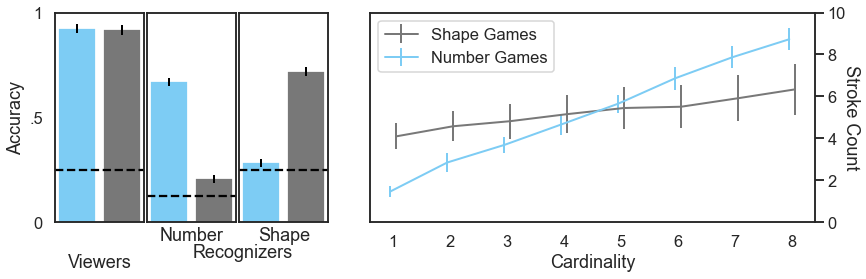

In [24]:
# Figure 2B

acc_DF = get_confint(pd.DataFrame(D1.groupby(['Game_Condition'])['outcome'].agg(['mean', 'count', 'std'])))
condition_acc = get_confint(pd.DataFrame(D2.groupby(['Rcond','Ocond'])['correct'].agg(['mean', 'count', 'std']))).reset_index()        

fig , (ax1,ax2,ax3,ax0,ax4) = plt.subplots(1,5 , figsize = (12,4),
                                       gridspec_kw={'width_ratios': [2,2,2,.8,10]})

ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax3.set_ylim(0,1)

ax1.set_ylabel("Accuracy")
ax1.set_yticks([0,.5,1])
ax1.set_yticklabels(['0','.5','1'])
ax2.set_yticks([])
ax3.set_yticks([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_yticks([])
ax0.set_yticklabels([])
ax0.set_xticks([])
ax0.set_xticklabels([])
ax0.axis('off')


bars1 = ax1.bar(acc_DF.reset_index()['Game_Condition'],
        height=acc_DF['mean'],
        color = [c1,c2], alpha=1, edgecolor = [c1,c2],
        yerr= acc_DF['ci95_hi']-acc_DF['mean'],
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':lw})

number_acc = condition_acc[condition_acc['Rcond'] == 'number']
bars2 = ax2.bar(number_acc['Ocond'],
        height=number_acc['mean'],
        color = [c1,c2], alpha=1, edgecolor = [c1,c2],
        yerr= number_acc['ci95_hi']-number_acc['mean'],
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':lw})

shape_acc = condition_acc[condition_acc['Rcond'] == 'shape']
bars3 = ax3.bar(shape_acc['Ocond'],
        height=shape_acc['mean'],
        color = [c1,c2], alpha=1, edgecolor = [c1,c2],
        yerr= shape_acc['ci95_hi']-shape_acc['mean'],
        error_kw={'linewidth':lw,'capsize':cs,'markeredgewidth':lw})

# Reviewer 3 pointed out that these bars were poorly formatted. It turns out that plt's bar borders actually change the height of the bars(!!!)
# So, we'll reduce them on this figure to make it more legible
for bar in bars1:
    bar.set_linewidth(.25)
for bar in bars2:
    bar.set_linewidth(.25)
for bar in bars3:
    bar.set_linewidth(.25)


ax1.set_xticks([])
ax1.set_xticklabels([])
ax2.set_xticks([])
ax2.set_xticklabels([])
ax3.set_xticks([])
ax3.set_xticklabels([])
ax2.set_xlabel("Number")
ax3.set_xlabel("Shape")

ax1.set_xlabel("Viewers")
ax1.xaxis.set_label_coords(.5, -.15)


l1=ax1.axhline(0.25,color='black',ls='--')
l1.set_label('l1')

l2=ax2.axhline(0.125,color='black',ls='--')
l2.set_label('l2')

l3=ax3.axhline(0.25,color='black',ls='--')
l3.set_label('l3')


# Figure 2C
# Process the data to plot. First, we'll separate the conditions
df_num = D1.loc[D1['Game_Condition'] == 'number']
df_aml = D1.loc[D1['Game_Condition'] == 'shape']

# then calculate confidence intervals for estimated stroke count within each cardinality
num_str_trial_DF = get_confint(pd.DataFrame(df_num.groupby(['cardinality'])['numStrokes'].agg(['mean', 'count', 'std'])))
aml_str_trial_DF = get_confint(pd.DataFrame(df_aml.groupby(['cardinality'])['numStrokes'].agg(['mean', 'count', 'std'])))

# we'll plot each condition onto the axis separately
ax4.errorbar(np.arange(1,len(aml_str_trial_DF)+1)+.05, aml_str_trial_DF['mean'],
             yerr = aml_str_trial_DF['ci95_hi'] - aml_str_trial_DF['mean'],
             linewidth=lw, capsize=cs, elinewidth=lw, markeredgewidth=lw, c=c2)
ax4.errorbar(np.arange(1,len(num_str_trial_DF)+1)-.05, num_str_trial_DF['mean'],
             yerr = num_str_trial_DF['ci95_hi'] - num_str_trial_DF['mean'],
             linewidth=lw, capsize=cs, elinewidth=lw, markeredgewidth=lw, c=c1)

# add labels, etc
ax4.legend(('Shape Games','Number Games'),loc="upper left")
ax4.yaxis.tick_right()
ax4.set_xlabel("Cardinality")
ax4.set_ylabel("Stroke Count",rotation=270)
ax4.set_ylim(0,np.ceil(np.max(num_str_trial_DF['ci95_hi']))) # set y-limit to be the nearest integer above max err val
ax4.yaxis.set_label_position("right")
ax4.yaxis.set_label_coords(1.1, .5)


plt.tight_layout(w_pad=.3)

ax5 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
ax5.set_position(pos=[.1,.25,.37,.1])
ax5.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
ax5.set_xlabel("Recognizers")
ax5.set_ylabel("")


fig.savefig('../results/plots/Fig_2.pdf')
fig.savefig('../results/plots/Fig_2.png')
fig.savefig('../results/plots/Fig_2.svg')

# ax2.scatter([0.2,1.2], number_acc['mean'], s=2, color='black', zorder=100)


### <a name="fig3"></a> Figure 3 ([^](#top))

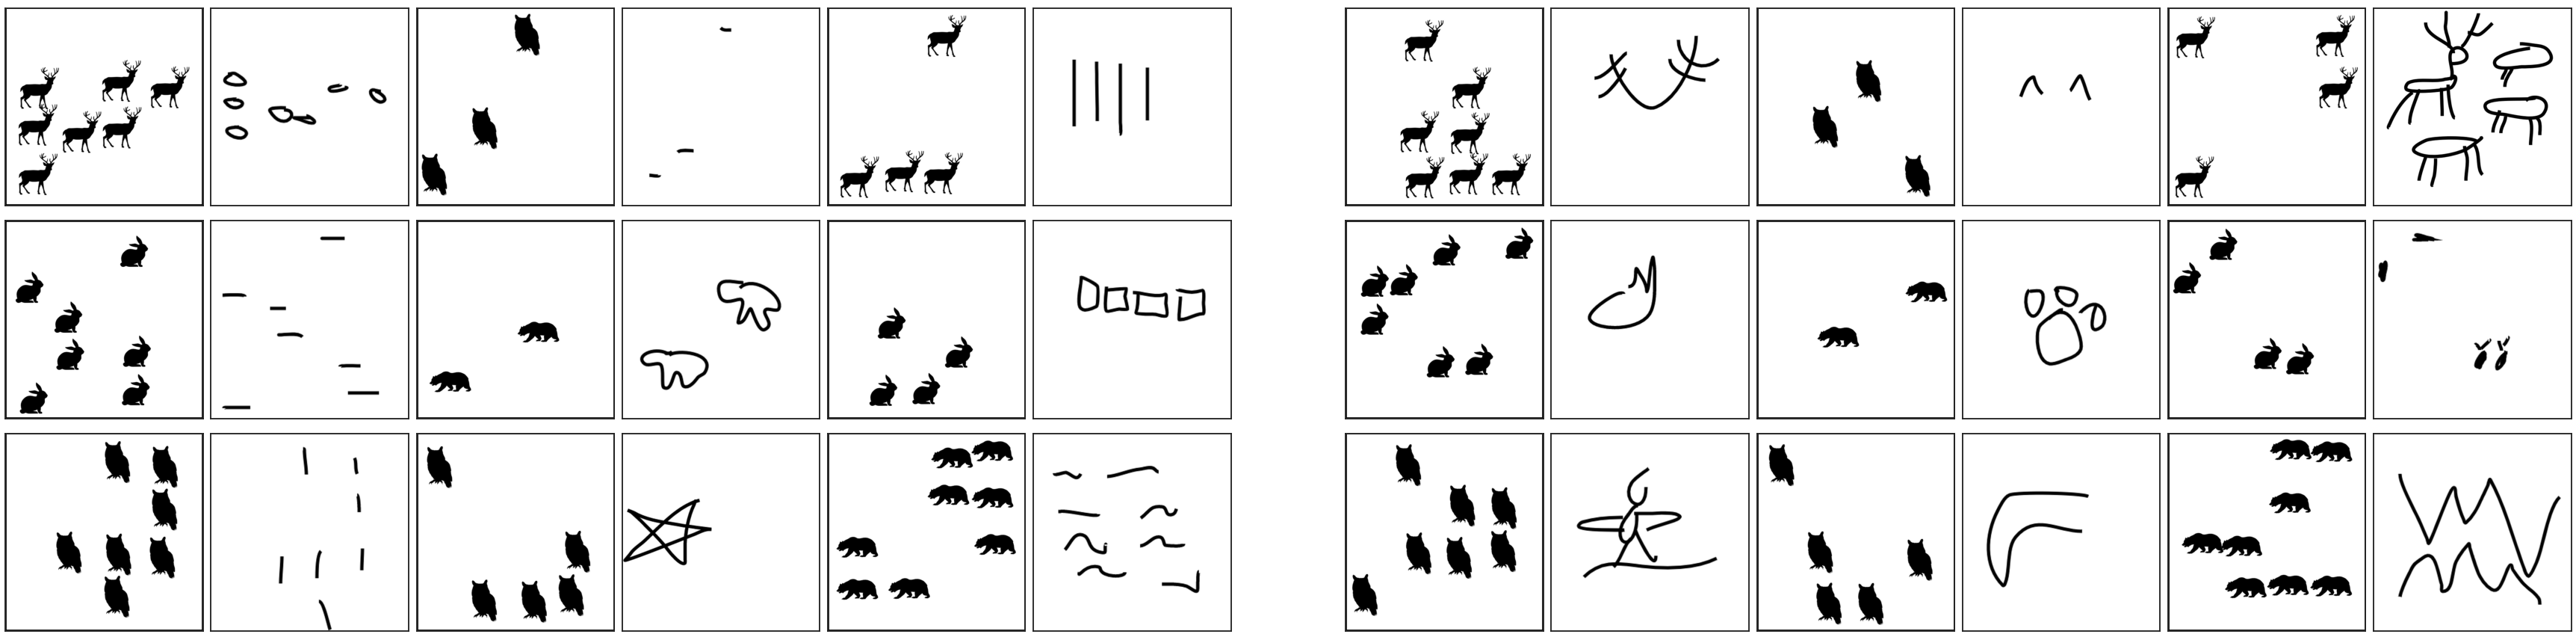

In [27]:
# indices within D1 dataframe of a selection of trials from number and shape games
num_inds =  [42,    100,  233]
num2_inds = [937,  1899, 1253]
num3_inds = [1753, 1420, 1162]
shp_inds =  [26,   1531, 1719]
shp2_inds = [1363, 1149,  506]
shp3_inds = [1668,  873,  523]

resize_dims = 1200    # we want to provide a reasonably high resolution, and 200 was not cutting it

f , axs = plt.subplots(len(num_inds),13,figsize=(48,4*len(num_inds)),sharex='col',sharey='col',gridspec_kw={'width_ratios': [4,4,4,4,4,4,2,4,4,4,4,4,4]})

for i,ind1 in enumerate(num_inds):
    ind2 = num2_inds[i]
    ind3 = num3_inds[i]
    ind4 = shp_inds[i]
    ind5 = shp2_inds[i]
    ind6 = shp3_inds[i]
    
    # Now plot our centroids to see if they look right:
    axs[i,0].imshow(io.imread(D1.at[ind1,'Targ_s_Url']))
    axs[i,1].imshow( Image.open(BytesIO(base64.b64decode(  D1.at[ind1,'png']  ))).resize((resize_dims,resize_dims)) )
    
    axs[i,2].imshow(io.imread(D1.at[ind2,'Targ_s_Url']))
    axs[i,3].imshow( Image.open(BytesIO(base64.b64decode(  D1.at[ind2,'png']  ))).resize((resize_dims,resize_dims)) )
    
    axs[i,4].imshow(io.imread(D1.at[ind3,'Targ_s_Url']))
    axs[i,5].imshow( Image.open(BytesIO(base64.b64decode(  D1.at[ind3,'png']  ))).resize((resize_dims,resize_dims)) )
    
    
    axs[i,7].imshow(io.imread(D1.at[ind4,'Targ_s_Url']))
    axs[i,8].imshow( Image.open(BytesIO(base64.b64decode(  D1.at[ind4,'png']  ))).resize((resize_dims,resize_dims)) )
    
    axs[i,9].imshow(io.imread(D1.at[ind5,'Targ_s_Url']))
    axs[i,10].imshow( Image.open(BytesIO(base64.b64decode(  D1.at[ind5,'png']  ))).resize((resize_dims,resize_dims)) )
    
    axs[i,11].imshow(io.imread(D1.at[ind6,'Targ_s_Url']))
    axs[i,12].imshow( Image.open(BytesIO(base64.b64decode(  D1.at[ind6,'png']  ))).resize((resize_dims,resize_dims)) )
    
    
    for j in range(13):
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
    
    axs[i,6].spines['top'].set_visible(False)
    axs[i,6].spines['right'].set_visible(False)
    axs[i,6].spines['bottom'].set_visible(False)
    axs[i,6].spines['left'].set_visible(False)

plt.tight_layout()

f.savefig('../results/plots/Fig_3.pdf')
f.savefig('../results/plots/Fig_3.png')
f.savefig('../results/plots/Fig_3.svg')

### <a name="fig4"></a> Figure 4 ([^](#top))

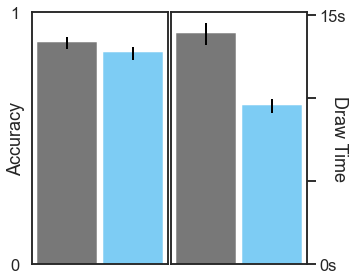

In [28]:
acc_DF = get_confint(pd.DataFrame(D3.groupby(['Regularity'])['outcome'].agg(['mean', 'count', 'std'])))
subject_acc = pd.DataFrame(D3.groupby(['Regularity','gameID'])['outcome'].mean()).reset_index()

fig , (ax1,ax2)= plt.subplots(1,2,figsize=(5,4),gridspec_kw={'width_ratios': [2, 2]})

barw = .35

ax1.bar([.3,.7],
        height=acc_DF['mean'],
        width=barw,
        yerr=[acc_DF['ci95_hi']-acc_DF['mean'], acc_DF['mean']-acc_DF['ci95_lo']],
        error_kw=dict(lw=lw, capsize=cs, capthick=lw))
ax1.set_ylim([0,1])
ax2.set_xlabel("")

ax1.get_children()[1].set_color(c2) # was hollow, as (0,0,0,0)
ax1.get_children()[2].set_color(c1) # was hollow, as (0,0,0,0)
ax1.get_children()[1].set_edgecolor(c2)
ax1.get_children()[2].set_edgecolor(c1)


ran_acc_trial_DF = get_confint(pd.DataFrame(D3[D3['Regularity']=='random'].groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))
reg_acc_trial_DF = get_confint(pd.DataFrame(D3[D3['Regularity']=='regular'].groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))

# show points as subject accuracies:
ran_subject_acc = np.array(subject_acc[subject_acc['Regularity']=='random']['outcome'])
reg_subject_acc = np.array(subject_acc[subject_acc['Regularity']=='regular']['outcome'])



time_DF = get_confint(pd.DataFrame(D3.groupby(['Regularity'])['drawDuration'].agg(['mean', 'count', 'std'])))
subject_time = pd.DataFrame(D3.groupby(['Regularity','gameID'])['drawDuration'].mean()).reset_index()

ax2.bar([.3,.7],
        height=time_DF['mean'],
        width=barw,
        yerr=[time_DF['ci95_hi']-time_DF['mean'], time_DF['mean']-time_DF['ci95_lo']],
        error_kw=dict(lw=lw, capsize=cs, capthick=lw))
ax2.set_xlabel("")

ax2.get_children()[1].set_color(c2) # was hollow, as (0,0,0,0)
ax2.get_children()[2].set_color(c1) # was hollow, as (0,0,0,0)
ax2.get_children()[1].set_edgecolor(c2)
ax2.get_children()[2].set_edgecolor(c1)

# show points as subject draw times:
ran_subject_time = np.array(subject_time[subject_time['Regularity']=='random']['drawDuration'])
reg_subject_time = np.array(subject_time[subject_time['Regularity']=='regular']['drawDuration'])

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax1.set_yticks([0,1])
ax1.set_yticklabels(['0','1'])
ax2.set_yticks([0,5,10,15])
ax2.set_yticklabels(['0s','','','15s'])

ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Draw Time",rotation=270)
ax1.yaxis.set_label_coords(-.05, .5)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_label_coords(1.3, .5)



plt.tight_layout(w_pad=.3)

fig.savefig('../results/plots/Fig_4.pdf')
fig.savefig('../results/plots/Fig_4.png')
fig.savefig('../results/plots/Fig_4.svg')



### <a name="fig5"></a> Figure 5 ([^](#top))

### Setting Up

In [29]:
# 1. a function we're going to use
def getCI95(x,g=False):
    upper = np.mean(x) + 1.96*np.std(x)/math.sqrt((len(x)))
    lower = np.mean(x) - 1.96*np.std(x)/math.sqrt((len(x)))
    if g == True:
        upper = stats.gmean(x) + 1.96*stats.gstd(x)/math.sqrt((len(x)))
        lower = stats.gmean(x) - 1.96*stats.gstd(x)/math.sqrt((len(x)))

    return upper - lower

# 2. some extra columns we're going to use
D4[['1norm']] = D4[['symbolslist']].applymap(lambda x: x.count(1)/len(x))
D4[['2norm']] = D4[['symbolslist']].applymap(lambda x: x.count(2)/len(x))
D4[['3norm']] = D4[['symbolslist']].applymap(lambda x: x.count(3)/len(x))
D4[['4norm']] = D4[['symbolslist']].applymap(lambda x: x.count(4)/len(x))

# 3. let's look at the diversity in representations of each cardinality
classification = 'cardinality'

# 4. get the estimate for Simpson's diversity index
simpsons = D4.groupby([classification,'symbols'])[['symbols']].count(
).groupby(classification)[['symbols']].apply(
    lambda x: 1 - (sum([y*(y-1) for y in list(x['symbols'])]) / 
    (x['symbols'].sum()*(x['symbols'].sum() - 1))))

simpsons.name = 'Simpson'

# 5. now bootstrap some uncertainty around that measure
subset_sims = np.zeros([len(D4[classification].unique()),0])

for i in range(100):
    np.random.seed(i)
    subset_games = np.random.choice(D4.gameID.unique(), len(D4.gameID.unique()), replace=True)
    subset_D4 = D4[D4['gameID'].apply(lambda x: x in subset_games)]
    cur_sim = np.array(subset_D4.groupby([classification,'symbols'])[['symbols']].count(
    ).groupby(classification)[['symbols']].apply(
        lambda x: 1 - (sum([y*(y-1) for y in list(x['symbols'])]) / 
                       (x['symbols'].sum()*(x['symbols'].sum() - 1)))))
    
    subset_sims = np.append(subset_sims,np.array([cur_sim]).T,axis=1)
    
upperCI = np.quantile(subset_sims, .975, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
lowerCI = np.quantile(subset_sims, .025, axis=1, keepdims = True, interpolation = 'nearest') # can't use 'method' because my python is outdated
upperCI = pd.DataFrame(np.squeeze(upperCI), columns=['upper']).reset_index().rename(columns={'index':classification})
lowerCI = pd.DataFrame(np.squeeze(lowerCI), columns=['lower']).reset_index().rename(columns={'index':classification})


###  Plotting

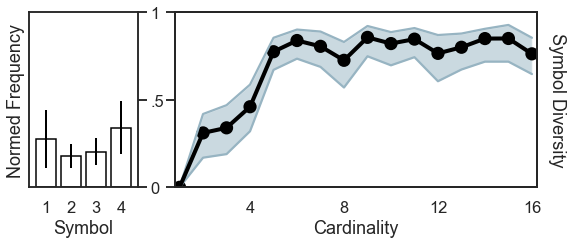

In [30]:
# plot 95-CI over the frequencies, with optional individual dots for each game
gameNormFreqs = D4.groupby(['gameID'])[['1norm','2norm','3norm','4norm']].mean()
mean = gameNormFreqs.mean()
yerr = D4.groupby(['gameID'])[['1norm','2norm','3norm','4norm']].mean().apply(getCI95)

f , (ax1,ax2) = plt.subplots(1,2,figsize=(8,3.5),sharey=True,
                             gridspec_kw={'width_ratios': [1.2, 4]})

barw = .8
mean.plot.bar(ax=ax1,
              yerr=yerr,
              xlabel="Symbol",
              ylabel='Normed Frequency',rot=0,
              width=barw,
              capsize=8,
              edgecolor='k',
              fill=None,
              error_kw=dict(ecolor='k',lw=lw, capsize=cs, capthick=lw))

for game in gameNormFreqs.index:
    offsets = (np.random.rand(4)-.5) / 4
    curMeansX = [0,1,2,3] + offsets
    curMeansY = gameNormFreqs.loc[game].T.to_frame()[game]
ax1.set_xticklabels(['1','2','3','4']) # we will replace these with images that are more intuitive


temp = pd.DataFrame(simpsons).reset_index()
sns.lineplot(data=upperCI, x=classification, y='upper',color=c3,ax=ax2)
sns.lineplot(data=lowerCI, x=classification, y='lower',color=c3,ax=ax2)
ax2.fill_between(upperCI[classification], lowerCI['lower'], upperCI['upper'], facecolor=c3, alpha=.5)
sns.pointplot(data=temp, x=classification, y='Simpson',color='k',markers='o',ax=ax2)

plt.ylim([0,1])
plt.xlabel("Cardinality")
ax1.set_xticklabels(['1','2','3','4'])




axes2 = ax2.twinx()
axes2.set_ylabel("Symbol Diversity",rotation=270)   # "Simpson's Diversity Index"
axes2.set_yticks([])
axes2.yaxis.set_label_coords(1.08 , .5)


ax1.set_yticks([])
ax1.set_yticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])


ax1.set_yticks([0,.5,1])
ax1.set_yticklabels(['0','.5','1'])
ax1.yaxis.tick_right()


ax2.set_xticks([3,7,11,15])
ax2.set_xticklabels(['4','8','12','16'])
ax2.set_xlim(-.2,15.2)


ax1.yaxis.set_minor_locator(plt.NullLocator())


plt.tight_layout(w_pad=.2)
f.savefig('../results/plots/Fig_5.pdf')
f.savefig('../results/plots/Fig_5.png')
f.savefig('../results/plots/Fig_5.svg')

